# **Image Matching Pipeline using SIFT + LightGlue**

Here's a detailed explanation of your **image matching pipeline** using SIFT + LightGlue in PyTorch/Kornia:

---

### **1️⃣ Imports and Setup**

```python
import os, io, requests, cv2, torch, kornia as K, kornia.feature as KF
from kornia_moons.feature import laf_from_opencv_SIFT_kpts
from kornia_moons.viz import draw_LAF_matches
import matplotlib.pyplot as plt
```

* **OpenCV (cv2)**: for SIFT keypoint detection.
* **Kornia / Kornia-Moons**: differentiable computer vision in PyTorch. Includes LightGlue matcher, LAF utilities, and visualization helpers.
* **Torch**: core tensor operations, device handling.
* **Matplotlib**: visualize matches.

---

### **2️⃣ Device Selection**

```python
compute_device = K.utils.get_cuda_or_mps_device_if_available()
print(compute_device)
```

* Chooses GPU if available (CUDA or Apple MPS).
* Speeds up descriptor matching and LightGlue computations.

---

### **3️⃣ LightGlue Matcher and SIFT Initialization**

```python
lightglue_model = KF.LightGlueMatcher("sift").eval().to(compute_device)
max_keypoints = 4096
sift_detector = cv2.SIFT_create(max_keypoints)
```

* **LightGlueMatcher("sift")**: pretrained model for SIFT descriptors.
* **SIFT_create(4096)**: detects up to 4096 features per image.

---

### **4️⃣ Image Loading**

```python
image_a = cv2.cvtColor(cv2.imread(img_path_1), cv2.COLOR_BGR2RGB)
image_b = cv2.cvtColor(cv2.imread(img_path_2), cv2.COLOR_BGR2RGB)
dims_a = torch.tensor(image_a.shape[:2], device=compute_device)
dims_b = torch.tensor(image_b.shape[:2], device=compute_device)
```

* Reads and converts OpenCV BGR → RGB.
* Stores height/width for LightGlue scaling.

---

### **5️⃣ Descriptor Normalization: RootSIFT**

```python
def convert_to_rootsift(desc: torch.Tensor, epsilon=1e-6) -> torch.Tensor:
    desc = torch.nn.functional.normalize(desc, p=1, dim=-1, eps=epsilon)
    desc.clip_(min=epsilon).sqrt_()
    return torch.nn.functional.normalize(desc, p=2, dim=-1, eps=epsilon)
```

* **RootSIFT** improves SIFT matching by:

  1. L1-normalizing the descriptor.
  2. Taking square root (Hellinger kernel).
  3. L2-normalizing again.

---

### **6️⃣ Detect Keypoints and Compute Descriptors**

```python
with torch.inference_mode():
    keypoints_a, descriptors_a = sift_detector.detectAndCompute(image_a, None)
    keypoints_b, descriptors_b = sift_detector.detectAndCompute(image_b, None)
```

* Uses OpenCV SIFT to extract **keypoints** and **descriptors**.

```python
frames_a = laf_from_opencv_SIFT_kpts(keypoints_a, compute_device)
frames_b = laf_from_opencv_SIFT_kpts(keypoints_b, compute_device)
descriptors_a = convert_to_rootsift(torch.from_numpy(descriptors_a)).to(compute_device)
descriptors_b = convert_to_rootsift(torch.from_numpy(descriptors_b)).to(compute_device)
```

* Converts OpenCV keypoints → **Local Affine Frames (LAFs)** compatible with Kornia.
* Converts descriptors to PyTorch and applies **RootSIFT**.

---

### **7️⃣ LightGlue Matching**

```python
distances, match_indices = lightglue_model(descriptors_a, descriptors_b, frames_a, frames_b, hw1=dims_a, hw2=dims_b)
```

* LightGlue produces **tentative matches** between two sets of descriptors using attention-based matching.
* `match_indices` contains matched indices: `(idx_image_a, idx_image_b)`.

```python
print(f"{match_indices.shape[0]} tentative matches with SIFT-LightGlue")
```

---

### **8️⃣ Extract Matched Keypoints**

```python
def extract_matched_points(points_a, points_b, match_indices):
    matched_pts_a = points_a[match_indices[:, 0]]
    matched_pts_b = points_b[match_indices[:, 1]]
    return matched_pts_a, matched_pts_b

matched_pts_a, matched_pts_b = extract_matched_points(KF.get_laf_center(frames_a)[0], KF.get_laf_center(frames_b)[0], match_indices.detach().cpu())
```

* Converts LAFs → **keypoint centers**.
* Retrieves matched coordinates for both images.

---

### **9️⃣ Estimate Fundamental Matrix + Inliers**

```python
fundamental_mat, inlier_mask = cv2.findFundamentalMat(
    matched_pts_a.detach().cpu().numpy(), matched_pts_b.detach().cpu().numpy(),
    cv2.USAC_MAGSAC, 1.5, 0.999, 100000
)
inlier_mask = inlier_mask > 0
```

* **RANSAC-based fundamental matrix estimation**.
* Filters out outliers to keep only **geometrically consistent matches**.

---

### **🔟 Visualize Matches**

```python
draw_LAF_matches(
    frames_a, frames_b,
    match_indices.cpu().numpy(),
    image_a, image_b,
    inlier_mask,
    draw_dict={
        "inlier_color": (0.2, 1, 0.2),
        "tentative_color": (1, 1, 0.2, 0.3),
        "feature_color": None,
        "vertical": False
    },
)
plt.title(f"{inlier_mask.sum()} inliers with SIFT-LightGlue")
```

* Draws tentative matches (yellow) and **inliers** (green) between images.
* LAFs allow visualization of **keypoint affine frames**, not just points.

---

### ✅ **Pipeline Summary**

1. Load images and initialize SIFT.
2. Detect keypoints & compute SIFT descriptors.
3. Convert keypoints → LAFs (affine frames).
4. Convert descriptors → RootSIFT + PyTorch tensors.
5. Run **LightGlue** to get tentative matches.
6. Extract keypoint coordinates from LAFs.
7. Compute **fundamental matrix** to filter inliers.
8. Visualize matches with LAFs and inlier overlay.

This approach combines **classic SIFT features** with **modern LightGlue attention-based matching**, giving robust matches even under scale, rotation, and lighting changes.

---

If you want, I can also **draw a step-by-step diagram** showing this pipeline visually from images → SIFT → LightGlue → inliers. It helps a lot for presentations. Do you want me to do that?

In [1]:
# Using LightGlue via kornia requires kornia>=0.7.2
!pip install kornia==0.7.2
!pip install kornia_moons --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 825.4/825.4 kB 13.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: kornia
    Found existing installation: kornia 0.8.2
    Uninstalling kornia-0.8.2:
      Successfully uninstalled kornia-0.8.2


In [2]:
!mkdir -p .cache/torch/hub/checkpoints
!cp /kaggle/input/lightglue/pytorch/sift/1/sift_lightglue.pth .cache/torch/hub/checkpoints/

cp: cannot stat '/kaggle/input/lightglue/pytorch/sift/1/sift_lightglue.pth': No such file or directory


In [3]:
import os
import io
import requests
import cv2
import kornia as K
import kornia.feature as KF
import matplotlib.pyplot as plt
import torch
from kornia_moons.feature import laf_from_opencv_SIFT_kpts
from kornia_moons.viz import draw_LAF_matches
import numpy as np

/usr/local/lib/python3.12/dist-packages/kornia/feature/lightglue.py:44: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  @torch.cuda.amp.custom_fwd(cast_inputs=torch.float32)


In [4]:
img_path_1 = "/kaggle/input/image-matching-challenge-2024/train/church/images/00017.png"
img_path_2 = "/kaggle/input/image-matching-challenge-2024/train/church/images/00020.png"

In [5]:
def convert_to_rootsift(desc: torch.Tensor, epsilon=1e-6) -> torch.Tensor:
    desc = torch.nn.functional.normalize(desc, p=1, dim=-1, eps=epsilon)
    desc.clip_(min=epsilon).sqrt_()
    return torch.nn.functional.normalize(desc, p=2, dim=-1, eps=epsilon)

compute_device = K.utils.get_cuda_or_mps_device_if_available()
print(compute_device)


lightglue_model = KF.LightGlueMatcher("sift").eval().to(compute_device)

max_keypoints = 4096
sift_detector = cv2.SIFT_create(max_keypoints)

image_a = cv2.cvtColor(cv2.imread(img_path_1), cv2.COLOR_BGR2RGB)
image_b = cv2.cvtColor(cv2.imread(img_path_2), cv2.COLOR_BGR2RGB)

dims_a = torch.tensor(image_a.shape[:2], device=compute_device)
dims_b = torch.tensor(image_b.shape[:2], device=compute_device)


with torch.inference_mode():
    keypoints_a, descriptors_a = sift_detector.detectAndCompute(image_a, None)
    keypoints_b, descriptors_b = sift_detector.detectAndCompute(image_b, None)
    frames_a = laf_from_opencv_SIFT_kpts(keypoints_a, compute_device)
    frames_b = laf_from_opencv_SIFT_kpts(keypoints_b, compute_device)
    descriptors_a = convert_to_rootsift(torch.from_numpy(descriptors_a)).to(compute_device)
    descriptors_b = convert_to_rootsift(torch.from_numpy(descriptors_b)).to(compute_device)
    distances, match_indices = lightglue_model(descriptors_a, descriptors_b, frames_a, frames_b, hw1=dims_a, hw2=dims_b)

print(f"{match_indices.shape[0]} tentative matches with SIFT-LightGlue")

cpu
Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/sift_lightglue.pth" to /root/.cache/torch/hub/checkpoints/sift_lightglue_v0-1_arxiv-pth


100%|██████████| 45.4M/45.4M [00:01<00:00, 43.0MB/s]


Loaded LightGlue model


/usr/local/lib/python3.12/dist-packages/kornia/feature/integrated.py:464: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hw1_ = torch.tensor(hw1, device=dev)
/usr/local/lib/python3.12/dist-packages/kornia/feature/integrated.py:468: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  hw2_ = torch.tensor(hw2, device=dev)


32 tentative matches with SIFT-LightGlue


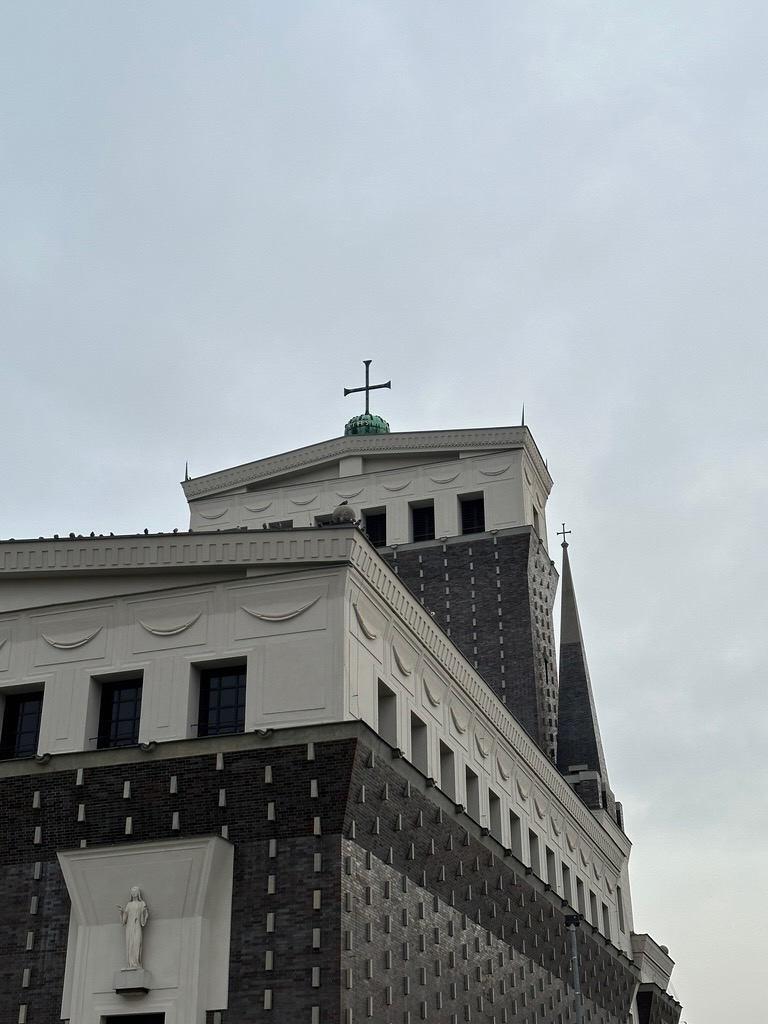

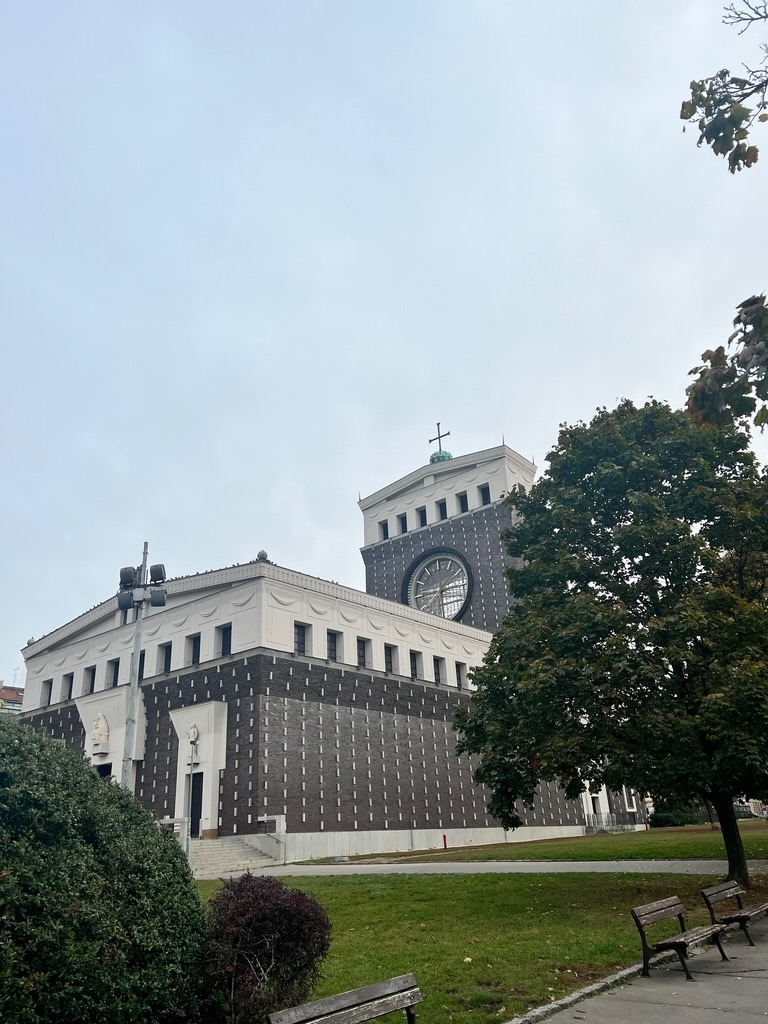

In [6]:
from PIL import Image
preview_a = Image.open(img_path_1)
preview_b = Image.open(img_path_2)
display(preview_a)
display(preview_b)

Text(0.5, 1.0, '18 inliers with SIFT-LightGlue')

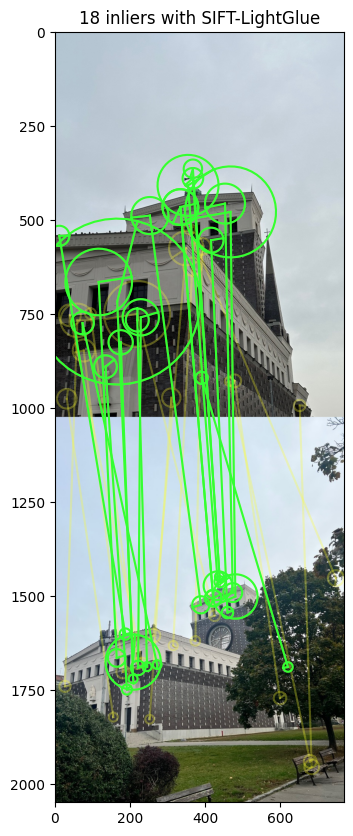

In [7]:
def extract_matched_points(points_a, points_b, match_indices):
    matched_pts_a = points_a[match_indices[:, 0]]
    matched_pts_b = points_b[match_indices[:, 1]]
    return matched_pts_a, matched_pts_b


matched_pts_a, matched_pts_b = extract_matched_points(KF.get_laf_center(frames_a)[0], KF.get_laf_center(frames_b)[0], match_indices.detach().cpu())

fundamental_mat, inlier_mask = cv2.findFundamentalMat(
    matched_pts_a.detach().cpu().numpy(), matched_pts_b.detach().cpu().numpy(), cv2.USAC_MAGSAC, 1.5, 0.999, 100000
)
inlier_mask = inlier_mask > 0

draw_LAF_matches(
    frames_a, 
    frames_b,
    match_indices.cpu().numpy(),
    image_a,
    image_b,
    inlier_mask,
    draw_dict={"inlier_color": (0.2, 1, 0.2), 
               "tentative_color": (1, 1, 0.2, 0.3), 
               "feature_color": None, 
               "vertical": True},
)
plt.title(f"{inlier_mask.sum()} inliers with SIFT-LightGlue")

138 tentative matches with SIFT-LightGlue (pair 2)


Text(0.5, 1.0, '80 inliers with SIFT-LightGlue (pair 2)')

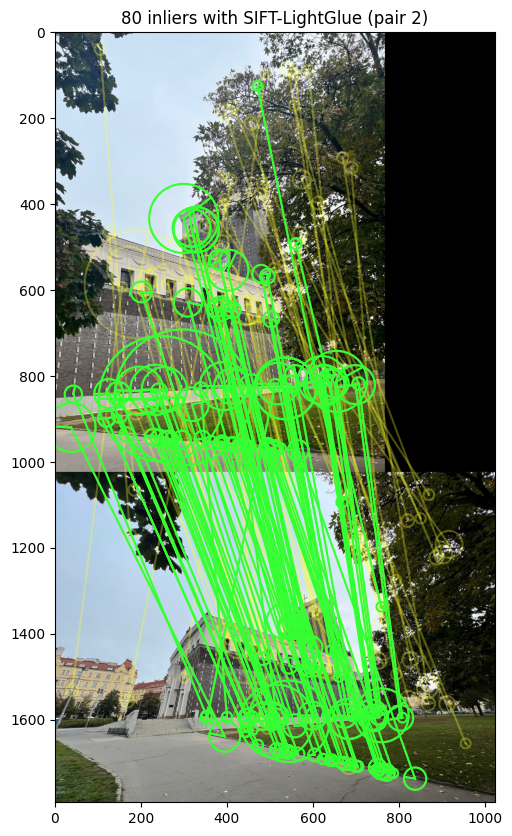

In [8]:
# --- Second image pair ---
img_path_3 = "/kaggle/input/image-matching-challenge-2024/train/church/images/00021.png"
img_path_4 = "/kaggle/input/image-matching-challenge-2024/train/church/images/00022.png"

image_c = cv2.cvtColor(cv2.imread(img_path_3), cv2.COLOR_BGR2RGB)
image_d = cv2.cvtColor(cv2.imread(img_path_4), cv2.COLOR_BGR2RGB)

dims_c = torch.tensor(image_c.shape[:2], device=compute_device)
dims_d = torch.tensor(image_d.shape[:2], device=compute_device)

with torch.inference_mode():
    keypoints_c, descriptors_c = sift_detector.detectAndCompute(image_c, None)
    keypoints_d, descriptors_d = sift_detector.detectAndCompute(image_d, None)
    frames_c = laf_from_opencv_SIFT_kpts(keypoints_c, compute_device)
    frames_d = laf_from_opencv_SIFT_kpts(keypoints_d, compute_device)
    descriptors_c = convert_to_rootsift(torch.from_numpy(descriptors_c)).to(compute_device)
    descriptors_d = convert_to_rootsift(torch.from_numpy(descriptors_d)).to(compute_device)
    distances_cd, match_indices_cd = lightglue_model(descriptors_c, descriptors_d, frames_c, frames_d, hw1=dims_c, hw2=dims_d)

print(f"{match_indices_cd.shape[0]} tentative matches with SIFT-LightGlue (pair 2)")

matched_pts_c, matched_pts_d = extract_matched_points(KF.get_laf_center(frames_c)[0], KF.get_laf_center(frames_d)[0], match_indices_cd.detach().cpu())

fundamental_mat_cd, inlier_mask_cd = cv2.findFundamentalMat(
    matched_pts_c.detach().cpu().numpy(), matched_pts_d.detach().cpu().numpy(), cv2.USAC_MAGSAC, 1.5, 0.999, 100000
)
inlier_mask_cd = inlier_mask_cd > 0

draw_LAF_matches(
    frames_c, 
    frames_d,
    match_indices_cd.cpu().numpy(),
    image_c,
    image_d,
    inlier_mask_cd,
    draw_dict={"inlier_color": (0.2, 1, 0.2), 
               "tentative_color": (1, 1, 0.2, 0.3), 
               "feature_color": None, 
               "vertical": True},
)
plt.title(f"{inlier_mask_cd.sum()} inliers with SIFT-LightGlue (pair 2)")

65 tentative matches with SIFT-LightGlue (pair 3)


Text(0.5, 1.0, '28 inliers with SIFT-LightGlue (pair 3)')

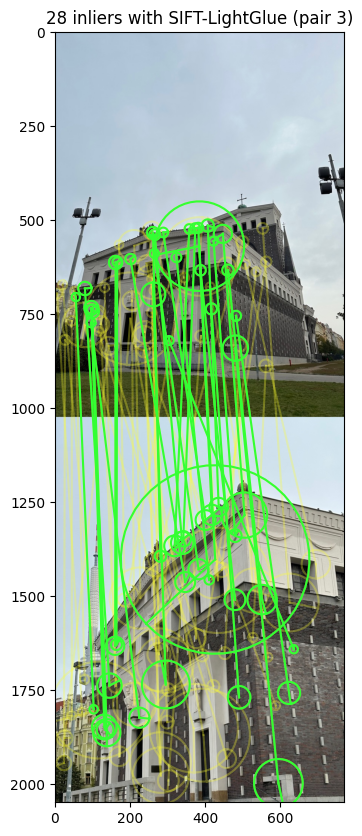

In [9]:
# --- Third image pair ---
img_path_5 = "/kaggle/input/image-matching-challenge-2024/train/church/images/00023.png"
img_path_6 = "/kaggle/input/image-matching-challenge-2024/train/church/images/00024.png"

image_e = cv2.cvtColor(cv2.imread(img_path_5), cv2.COLOR_BGR2RGB)
image_f = cv2.cvtColor(cv2.imread(img_path_6), cv2.COLOR_BGR2RGB)

dims_e = torch.tensor(image_e.shape[:2], device=compute_device)
dims_f = torch.tensor(image_f.shape[:2], device=compute_device)

with torch.inference_mode():
    keypoints_e, descriptors_e = sift_detector.detectAndCompute(image_e, None)
    keypoints_f, descriptors_f = sift_detector.detectAndCompute(image_f, None)
    frames_e = laf_from_opencv_SIFT_kpts(keypoints_e, compute_device)
    frames_f = laf_from_opencv_SIFT_kpts(keypoints_f, compute_device)
    descriptors_e = convert_to_rootsift(torch.from_numpy(descriptors_e)).to(compute_device)
    descriptors_f = convert_to_rootsift(torch.from_numpy(descriptors_f)).to(compute_device)
    distances_ef, match_indices_ef = lightglue_model(descriptors_e, descriptors_f, frames_e, frames_f, hw1=dims_e, hw2=dims_f)

print(f"{match_indices_ef.shape[0]} tentative matches with SIFT-LightGlue (pair 3)")

matched_pts_e, matched_pts_f = extract_matched_points(KF.get_laf_center(frames_e)[0], KF.get_laf_center(frames_f)[0], match_indices_ef.detach().cpu())

fundamental_mat_ef, inlier_mask_ef = cv2.findFundamentalMat(
    matched_pts_e.detach().cpu().numpy(), matched_pts_f.detach().cpu().numpy(), cv2.USAC_MAGSAC, 1.5, 0.999, 100000
)
inlier_mask_ef = inlier_mask_ef > 0

draw_LAF_matches(
    frames_e, 
    frames_f,
    match_indices_ef.cpu().numpy(),
    image_e,
    image_f,
    inlier_mask_ef,
    draw_dict={"inlier_color": (0.2, 1, 0.2), 
               "tentative_color": (1, 1, 0.2, 0.3), 
               "feature_color": None, 
               "vertical": True},
)
plt.title(f"{inlier_mask_ef.sum()} inliers with SIFT-LightGlue (pair 3)")

40 tentative matches with SIFT-LightGlue (pair 4)


Text(0.5, 1.0, '12 inliers with SIFT-LightGlue (pair 4)')

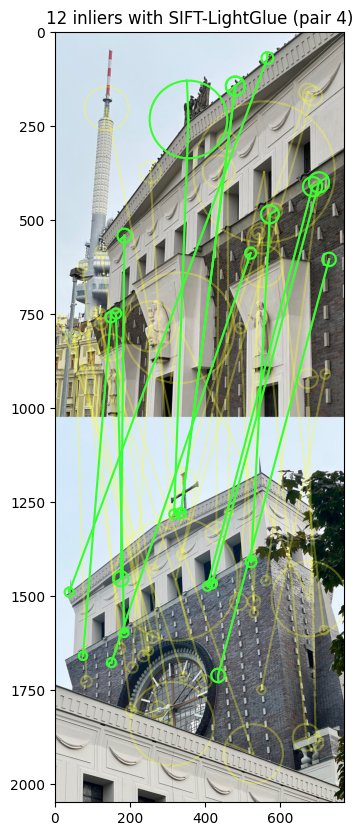

In [10]:
# --- Fourth image pair ---
img_path_7 = "/kaggle/input/image-matching-challenge-2024/train/church/images/00025.png"
img_path_8 = "/kaggle/input/image-matching-challenge-2024/train/church/images/00026.png"

image_g = cv2.cvtColor(cv2.imread(img_path_7), cv2.COLOR_BGR2RGB)
image_h = cv2.cvtColor(cv2.imread(img_path_8), cv2.COLOR_BGR2RGB)

dims_g = torch.tensor(image_g.shape[:2], device=compute_device)
dims_h = torch.tensor(image_h.shape[:2], device=compute_device)

with torch.inference_mode():
    keypoints_g, descriptors_g = sift_detector.detectAndCompute(image_g, None)
    keypoints_h, descriptors_h = sift_detector.detectAndCompute(image_h, None)
    frames_g = laf_from_opencv_SIFT_kpts(keypoints_g, compute_device)
    frames_h = laf_from_opencv_SIFT_kpts(keypoints_h, compute_device)
    descriptors_g = convert_to_rootsift(torch.from_numpy(descriptors_g)).to(compute_device)
    descriptors_h = convert_to_rootsift(torch.from_numpy(descriptors_h)).to(compute_device)
    distances_gh, match_indices_gh = lightglue_model(descriptors_g, descriptors_h, frames_g, frames_h, hw1=dims_g, hw2=dims_h)

print(f"{match_indices_gh.shape[0]} tentative matches with SIFT-LightGlue (pair 4)")

matched_pts_g, matched_pts_h = extract_matched_points(KF.get_laf_center(frames_g)[0], KF.get_laf_center(frames_h)[0], match_indices_gh.detach().cpu())

fundamental_mat_gh, inlier_mask_gh = cv2.findFundamentalMat(
    matched_pts_g.detach().cpu().numpy(), matched_pts_h.detach().cpu().numpy(), cv2.USAC_MAGSAC, 1.5, 0.999, 100000
)
inlier_mask_gh = inlier_mask_gh > 0

draw_LAF_matches(
    frames_g, 
    frames_h,
    match_indices_gh.cpu().numpy(),
    image_g,
    image_h,
    inlier_mask_gh,
    draw_dict={"inlier_color": (0.2, 1, 0.2), 
               "tentative_color": (1, 1, 0.2, 0.3), 
               "feature_color": None, 
               "vertical": True},
)
plt.title(f"{inlier_mask_gh.sum()} inliers with SIFT-LightGlue (pair 4)")